In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import *
from keras import regularizers, utils
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

Using TensorFlow backend.


# Upload data

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('val.csv')

In [3]:
train.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
0,0.28305,0.52361,0.69209,0.44205,0.43505,0.76235,0.31014,0.69990,0.32579,0.72926,0.33439,0.41445,0.30291,0.56754,0.41035,0.30540,0.70217,0.67645,0.33197,0.62004,0.40567,0
1,0.72306,0.55033,0.39225,0.63030,0.56429,0.33871,0.48310,0.29581,0.60988,0.49206,0.60155,0.62379,0.63850,0.44519,0.40625,0.63020,0.36515,0.39648,0.49776,0.37858,0.41617,1
2,0.29881,0.48360,0.74775,0.35139,0.34590,0.59046,0.47939,0.67480,0.20389,0.64569,0.27525,0.36862,0.25399,0.69524,0.54931,0.24025,0.73879,0.74283,0.46221,0.61501,0.44855,0
3,0.51999,0.62361,0.55290,0.53790,0.45459,0.48424,0.55901,0.44721,0.26035,0.61347,0.47019,0.56532,0.45956,0.64501,0.63455,0.41849,0.53119,0.54691,0.58776,0.39615,0.32122,1
4,0.47968,0.56531,0.58870,0.44709,0.43121,0.48611,0.53326,0.52356,0.30413,0.62464,0.40931,0.48232,0.41466,0.63677,0.53184,0.41226,0.57170,0.60222,0.48431,0.50111,0.40677,1


In [4]:
test.head()

,id,era,data_type,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
0,55113,era97,validation,0.56211,0.48552,0.61290,0.39826,0.37009,0.41959,0.67384,0.41264,0.36229,0.46753,0.38081,0.41642,0.42825,0.70212,0.60207,0.41624,0.56321,0.62616,0.62193,0.49730,0.51432,1
1,9835,era97,validation,0.50865,0.60490,0.52614,0.53751,0.51433,0.66610,0.43490,0.49711,0.32425,0.62434,0.48321,0.52867,0.48310,0.53141,0.46809,0.46428,0.51586,0.52340,0.43596,0.47253,0.38056,1
2,150614,era97,validation,0.50124,0.46113,0.60613,0.43473,0.42881,0.52306,0.49339,0.49767,0.41923,0.51487,0.39567,0.42224,0.42181,0.57629,0.44828,0.41719,0.58024,0.60782,0.46928,0.55603,0.51480,1
3,80064,era97,validation,0.42507,0.43184,0.67858,0.33142,0.36523,0.48837,0.52327,0.58739,0.37439,0.55422,0.30746,0.34585,0.33598,0.64555,0.44551,0.35940,0.65535,0.69759,0.42920,0.63423,0.55336,0
4,116911,era97,validation,0.45803,0.60370,0.49455,0.57237,0.59102,0.66634,0.26381,0.58187,0.38376,0.73428,0.52126,0.58425,0.48764,0.41904,0.34250,0.46747,0.51608,0.48878,0.31060,0.50326,0.33420,0


# Drop useless columns

In [0]:
del test['id']
del test['era']
del test['data_type']

In [6]:
test.shape

(16686, 22)

In [0]:
train_y = train['target'].values
del train['target']
train_x = train.copy().values

In [0]:
test_y = test['target'].values
del test['target']
test_x = test.copy().values

# Split train data on validation and training datasets

In [8]:
from sklearn.feature_selection import RFECV, RFE
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(n_jobs=-1)
selector = RFECV(lr)
select = selector.fit(train_x, train_y)
train_x = select.transform(train_x)
test_x = select.transform(test_x)

x_train, val_x, y_train, val_y = train_test_split(train_x, train_y, test_size=0.3)

# Normalize data
min_max = preprocessing.MinMaxScaler()
x_train = min_max.fit_transform(x_train)
test_x = min_max.transform(test_x)
val_x = min_max.transform(val_x)

# Make one-hot encoding
y_train = utils.to_categorical(y_train, 2)
test_y = utils.to_categorical(test_y, 2)
val_y = utils.to_categorical(val_y, 2)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not 

# 1) Create model

In [83]:
input_shape = train_x.shape
epochs = 50
batch_size = 128

model_1 = Sequential([
    InputLayer(input_shape=(input_shape[1], )),
    
    Dense(32),
    Activation('tanh'),

    Dense(16),
    Activation('tanh'),

    Dense(2, activation='softmax')
])
print(model_1.summary())

model_checkpoint = ModelCheckpoint('model-{epoch:02d}-{val_acc:.2f}.h5', verbose=1, save_best_only=True)

model_1.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(val_x, val_y), callbacks=[model_checkpoint])
evals = model_1.evaluate(test_x, test_y)
print(evals)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_141 (Dense)            (None, 32)                576       
_________________________________________________________________
activation_52 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_142 (Dense)            (None, 16)                528       
_________________________________________________________________
activation_53 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_143 (Dense)            (None, 2)                 34        
Total params: 1,138
Trainable params: 1,138
Non-trainable params: 0
_________________________________________________________________
None
Train on 75883 samples, validate on 32522 samples
Epoch 1/50
75883/75883 [==============================] - 11s 143us/step - loss: 0.69

### Visualize loss and accuracy

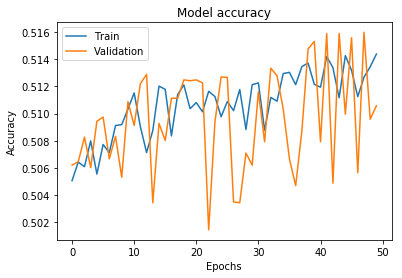

In [84]:
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

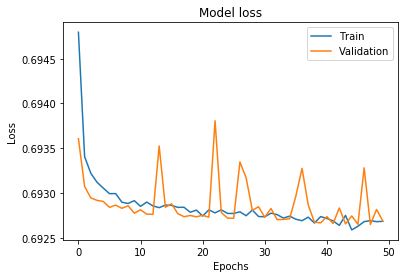

In [85]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# 2) Create model -> change 'tanh' on 'relu'

In [86]:
input_shape = train_x.shape
epochs = 50
batch_size = 128

model_2 = Sequential([
    InputLayer(input_shape=(input_shape[1], )),
    
    Dense(32),
    Activation('relu'),

    Dense(16),
    Activation('relu'),

    Dense(2, activation='softmax')
])
print(model_2.summary())

model_checkpoint = ModelCheckpoint('model-{epoch:02d}-{val_acc:.2f}.h5', verbose=1, save_best_only=True)

model_2.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(val_x, val_y), callbacks=[model_checkpoint])
evals = model_2.evaluate(test_x, test_y)
print(evals)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 32)                576       
_________________________________________________________________
activation_54 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_145 (Dense)            (None, 16)                528       
_________________________________________________________________
activation_55 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_146 (Dense)            (None, 2)                 34        
Total params: 1,138
Trainable params: 1,138
Non-trainable params: 0
_________________________________________________________________
None
Train on 75883 samples, validate on 32522 samples
Epoch 1/50
75883/75883 [==============================] - 11s 146us/step - loss: 0.69

### Visualize loss and accuracy

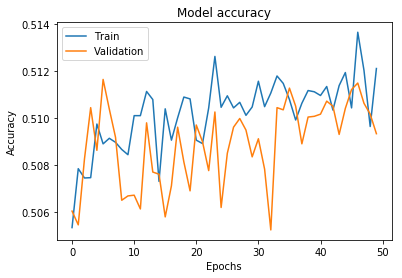

In [87]:
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

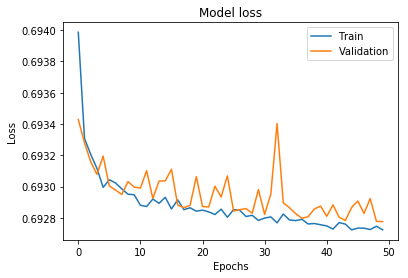

In [88]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# 3) Create model -> add more layers

In [89]:
input_shape = train_x.shape
epochs = 50
batch_size = 128

model_3 = Sequential([
    InputLayer(input_shape=(input_shape[1], )),
    
    Dense(32),
    Activation('relu'),
    
    Dense(16),
    Activation('relu'),
    
    Dense(8),
    Activation('relu'),

    Dense(4),
    Activation('relu'),

    Dense(2, activation='softmax')
])
print(model_3.summary())

model_checkpoint = ModelCheckpoint('model-{epoch:02d}-{val_acc:.2f}.h5', verbose=1, save_best_only=True)

model_3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(val_x, val_y), callbacks=[model_checkpoint])
evals = model_3.evaluate(test_x, test_y)
print(evals)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 32)                576       
_________________________________________________________________
activation_56 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_148 (Dense)            (None, 16)                528       
_________________________________________________________________
activation_57 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_149 (Dense)            (None, 8)                 136       
_________________________________________________________________
activation_58 (Activation)   (None, 8)                 0         
_________________________________________________________________
dense_150 (Dense)            (None, 4)                 36        
__________

### Visualize loss and accuracy

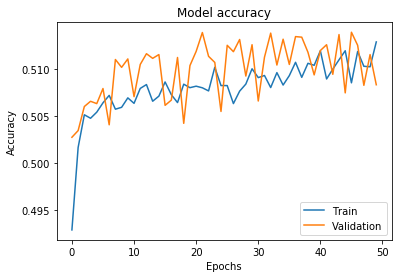

In [90]:
plt.plot(history_3.history['acc'])
plt.plot(history_3.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

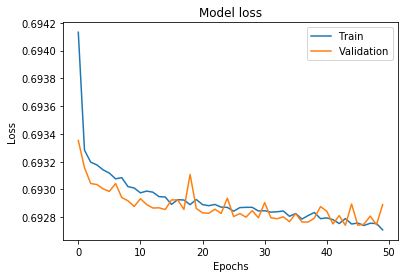

In [91]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# 4) Create model -> add more neurons, change optimizer on 'Adam'

In [92]:
input_shape = train_x.shape
epochs = 50
batch_size = 128

model_4 = Sequential([
    InputLayer(input_shape=(input_shape[1], )),
    
    Dense(128),
    Activation('relu'),
    
    Dense(64),
    Activation('relu'),
    
    Dense(32),
    Activation('relu'),

    Dense(16),
    Activation('relu'),

    Dense(2, activation='softmax')
])
print(model_4.summary())

model_checkpoint = ModelCheckpoint('model-{epoch:02d}-{val_acc:.2f}.h5', verbose=1, save_best_only=True)

model_4.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_4 = model_4.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(val_x, val_y), callbacks=[model_checkpoint])
evals = model_4.evaluate(test_x, test_y)
print(evals)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_152 (Dense)            (None, 128)               2304      
_________________________________________________________________
activation_60 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_153 (Dense)            (None, 64)                8256      
_________________________________________________________________
activation_61 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_154 (Dense)            (None, 32)                2080      
_________________________________________________________________
activation_62 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_155 (Dense)            (None, 16)                528       
__________

### Visualize loss and accuracy

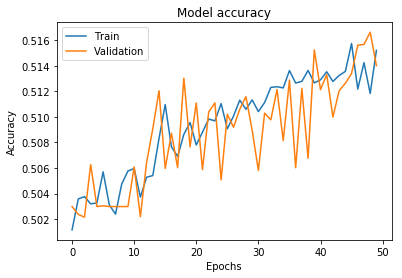

In [93]:
plt.plot(history_4.history['acc'])
plt.plot(history_4.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

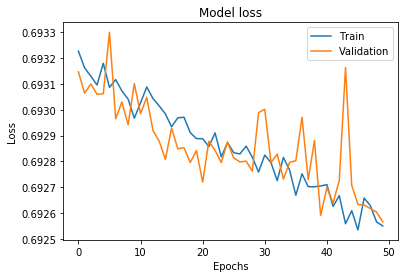

In [94]:
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# 5) Create model -> add kernel regularization

In [95]:
input_shape = train_x.shape
epochs = 50
batch_size = 128

model_5 = Sequential([
    InputLayer(input_shape=(input_shape[1], )),
    
    Dense(128, kernel_regularizer=regularizers.l2(0.001)),
    Activation('relu'),
    
    Dense(64, kernel_regularizer=regularizers.l2(0.001)),
    Activation('relu'),
    
    Dense(32, kernel_regularizer=regularizers.l2(0.001)),
    Activation('relu'),

    Dense(16, kernel_regularizer=regularizers.l2(0.001)),
    Activation('relu'),

    Dense(2, kernel_regularizer=regularizers.l2(0.001), activation='softmax')
])
print(model_5.summary())

model_checkpoint = ModelCheckpoint('model-{epoch:02d}-{val_acc:.2f}.h5', verbose=1, save_best_only=True)

model_5.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_5 = model_5.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(val_x, val_y), callbacks=[model_checkpoint])
evals = model_5.evaluate(test_x, test_y)
print(evals)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_157 (Dense)            (None, 128)               2304      
_________________________________________________________________
activation_64 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_158 (Dense)            (None, 64)                8256      
_________________________________________________________________
activation_65 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_159 (Dense)            (None, 32)                2080      
_________________________________________________________________
activation_66 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_160 (Dense)            (None, 16)                528       
__________

### Visualize loss and accuracy


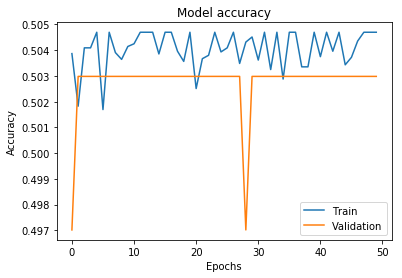

In [96]:
plt.plot(history_5.history['acc'])
plt.plot(history_5.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

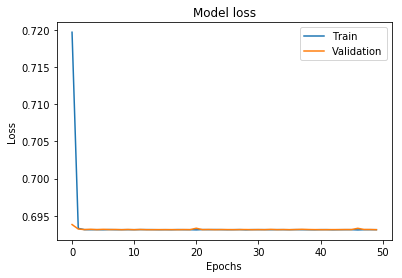

In [97]:
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# 6) Create model -> add dropout

In [98]:
input_shape = train_x.shape
epochs = 50
batch_size = 128

model_6 = Sequential([
    InputLayer(input_shape=(input_shape[1], )),
    
    Dense(128, kernel_regularizer=regularizers.l2(0.001)),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(64, kernel_regularizer=regularizers.l2(0.001)),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(32, kernel_regularizer=regularizers.l2(0.001)),
    Activation('relu'),
    Dropout(0.25),

    Dense(16, kernel_regularizer=regularizers.l2(0.001)),
    Activation('relu'),
    Dropout(0.25),

    Dense(2, kernel_regularizer=regularizers.l2(0.001), activation='softmax')
])
print(model_6.summary())

model_checkpoint = ModelCheckpoint('model-{epoch:02d}-{val_acc:.2f}.h5', verbose=1, save_best_only=True)

model_6.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_6 = model_6.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(val_x, val_y), callbacks=[model_checkpoint])
evals = model_6.evaluate(test_x, test_y)
print(evals)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_162 (Dense)            (None, 128)               2304      
_________________________________________________________________
activation_68 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_95 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_163 (Dense)            (None, 64)                8256      
_________________________________________________________________
activation_69 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_96 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_164 (Dense)            (None, 32)                2080      
__________

### Visualize loss and accuracy

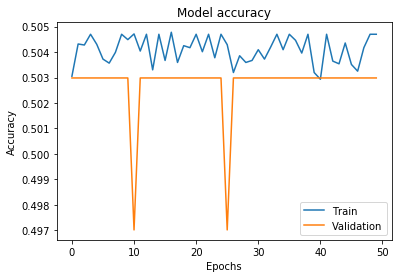

In [99]:
plt.plot(history_6.history['acc'])
plt.plot(history_6.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

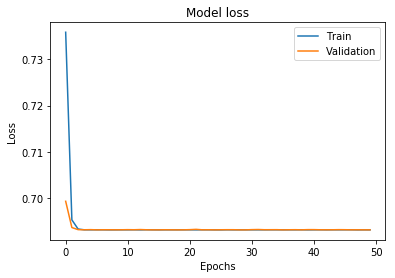

In [100]:
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# 7) Create model -> add  kernel_initializer='random_normal'

In [101]:
input_shape = train_x.shape
epochs = 50
batch_size = 128

model_7 = Sequential([
    InputLayer(input_shape=(input_shape[1], )),
    
    Dense(128, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(64, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(32, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.25),

    Dense(16, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.25),

    Dense(2, kernel_regularizer=regularizers.l2(0.001), activation='softmax',
             kernel_initializer='random_normal')
])
print(model_7.summary())

model_checkpoint = ModelCheckpoint('model-{epoch:02d}-{val_acc:.2f}.h5', verbose=1, save_best_only=True)

model_7.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_7 = model_7.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(val_x, val_y), callbacks=[model_checkpoint])
evals = model_7.evaluate(test_x, test_y)
print(evals)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_167 (Dense)            (None, 128)               2304      
_________________________________________________________________
activation_72 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_99 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_168 (Dense)            (None, 64)                8256      
_________________________________________________________________
activation_73 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_169 (Dense)            (None, 32)                2080      
__________

### Visualize loss and accuracy

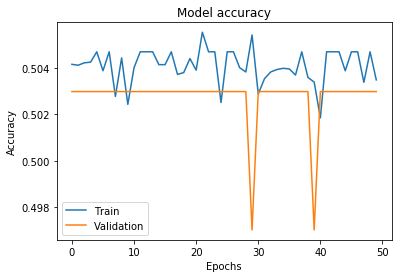

In [102]:
plt.plot(history_7.history['acc'])
plt.plot(history_7.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

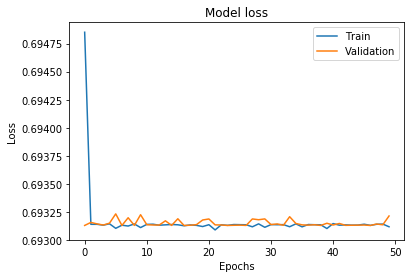

In [103]:
plt.plot(history_7.history['loss'])
plt.plot(history_7.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# 8) Create model -> customize Adam optimizer

In [104]:
input_shape = train_x.shape
epochs = 50
batch_size = 128

model_8 = Sequential([
    InputLayer(input_shape=(input_shape[1], )),
    
    Dense(128, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(64, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(32, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.25),

    Dense(16, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.25),

    Dense(2, kernel_regularizer=regularizers.l2(0.001), activation='softmax',
             kernel_initializer='random_normal')
])
print(model_8.summary())

model_checkpoint = ModelCheckpoint('model-{epoch:02d}-{val_acc:.2f}.h5', verbose=1, save_best_only=True)

model_8.compile(optimizer=optimizers.Adam(lr=0.0001, decay=0.001/100), 
                loss='categorical_crossentropy', metrics=['accuracy'])
history_8 = model_8.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(val_x, val_y), callbacks=[model_checkpoint])
evals = model_8.evaluate(test_x, test_y)
print(evals)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_172 (Dense)            (None, 128)               2304      
_________________________________________________________________
activation_76 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_103 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_173 (Dense)            (None, 64)                8256      
_________________________________________________________________
activation_77 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_104 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_174 (Dense)            (None, 32)                2080      
__________

### Visualize loss and accuracy

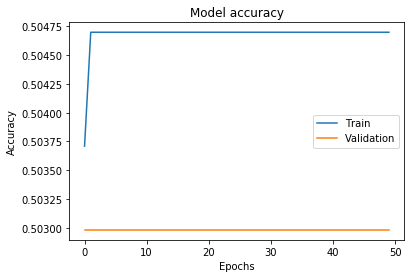

In [105]:
plt.plot(history_8.history['acc'])
plt.plot(history_8.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

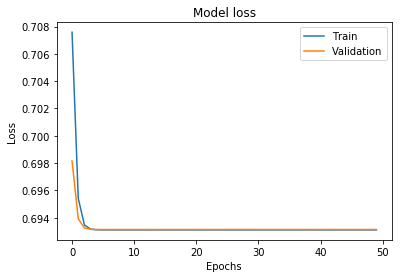

In [106]:
plt.plot(history_8.history['loss'])
plt.plot(history_8.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# 9) Create model -> add BatchNormalization and EarlyStopping callback

#### Причина того, что улучшения моделей (добаление слоёв, нейронов, регуляризаторов и т.д) не работают, потому что между слоями отсутствует скейлер -> поэтому добавлю и его в модель -> BatchNormalization()

In [107]:
input_shape = train_x.shape
epochs = 50
batch_size = 128

model_9 = Sequential([
    InputLayer(input_shape=(input_shape[1], )),
    
    Dense(128, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(64, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(32, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(16, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(2, kernel_regularizer=regularizers.l2(0.001), activation='softmax',
             kernel_initializer='random_normal')
])
print(model_9.summary())

model_checkpoint = ModelCheckpoint('model-{epoch:02d}-{val_acc:.2f}.h5', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')

model_9.compile(optimizer=optimizers.Adam(lr=0.0001, decay=0.001/100), 
                loss='categorical_crossentropy', metrics=['accuracy'])
history_9 = model_9.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(val_x, val_y), callbacks=[model_checkpoint, early_stopping])
evals = model_9.evaluate(test_x, test_y)
print(evals)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_177 (Dense)            (None, 128)               2304      
_________________________________________________________________
batch_normalization_116 (Bat (None, 128)               512       
_________________________________________________________________
activation_80 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_107 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_178 (Dense)            (None, 64)                8256      
_________________________________________________________________
batch_normalization_117 (Bat (None, 64)                256       
_________________________________________________________________
activation_81 (Activation)   (None, 64)                0         
__________

### Visualize loss and accuracy

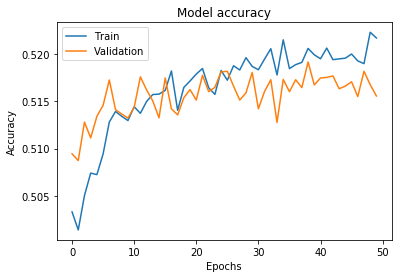

In [108]:
plt.plot(history_9.history['acc'])
plt.plot(history_9.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

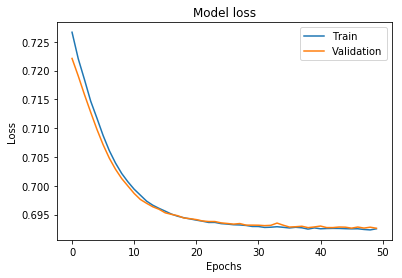

In [109]:
plt.plot(history_9.history['loss'])
plt.plot(history_9.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# 10) Create model and Add TensorBoard Visualization

### Для быстрой работы с TensorBoard в Colab я буду использывать специализированую библиотеку - tensorboardcolab

In [110]:
! pip install tensorboardcolab
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### После чего будет выдана ссылка на tensorboard сразу после print(model_10.summary()) ИЛИ можно увидеть всю нужную визуализацию непосредственно в самом notebook

In [111]:
from tensorboardcolab import *

input_shape = train_x.shape
epochs = 50
batch_size = 128

model_10 = Sequential([
    InputLayer(input_shape=(input_shape[1], )),
    
    Dense(16, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    

    Dense(8, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(4, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(2, kernel_regularizer=regularizers.l2(0.001), activation='softmax',
             kernel_initializer='random_normal')
])
print(model_10.summary())

model_checkpoint = ModelCheckpoint('model-{epoch:02d}-{val_acc:.2f}.h5', verbose=1, save_best_only=True)

# Create tensorboard callback
tbc=TensorBoardColab()

%tensorboard --logdir Graph

model_10.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_10 = model_10.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                          validation_data=(val_x, val_y), 
                          callbacks=[TensorBoardColabCallback(tbc), model_checkpoint])
evals = model_10.evaluate(test_x, test_y)
print(evals)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_182 (Dense)            (None, 16)                288       
_________________________________________________________________
batch_normalization_120 (Bat (None, 16)                64        
_________________________________________________________________
activation_84 (Activation)   (None, 16)                0         
_________________________________________________________________
dropout_111 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_183 (Dense)            (None, 8)                 136       
_________________________________________________________________
batch_normalization_121 (Bat (None, 8)                 32        
_________________________________________________________________
activation_85 (Activation)   (None, 8)                 0         
__________

Train on 75883 samples, validate on 32522 samples
Epoch 1/50
75883/75883 [==============================] - 9s 119us/step - loss: 0.6942 - acc: 0.5019 - val_loss: 0.6938 - val_acc: 0.5030

Epoch 00001: val_loss improved from inf to 0.69376, saving model to model-01-0.50.h5
Epoch 2/50
75883/75883 [==============================] - 6s 83us/step - loss: 0.6935 - acc: 0.5059 - val_loss: 0.6933 - val_acc: 0.5057

Epoch 00002: val_loss improved from 0.69376 to 0.69334, saving model to model-02-0.51.h5
Epoch 3/50
75883/75883 [==============================] - 6s 85us/step - loss: 0.6934 - acc: 0.5036 - val_loss: 0.6932 - val_acc: 0.5105

Epoch 00003: val_loss improved from 0.69334 to 0.69317, saving model to model-03-0.51.h5
Epoch 4/50
75883/75883 [==============================] - 7s 86us/step - loss: 0.6933 - acc: 0.5039 - val_loss: 0.6933 - val_acc: 0.5030

Epoch 00004: val_loss did not improve from 0.69317
Epoch 5/50
75883/75883 [==============================] - 6s 85us/step - loss: 0.69

# 11) Create model and Add Graph Visualization

### Граф можно визуализировать в tensorboard (перейдя во вкладку GRAPHS), что и было сделано в пункте 10. Осталось еще одна возможность - использывать функцию model_to_dot в Keras

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_186 (Dense)            (None, 16)                288       
_________________________________________________________________
batch_normalization_123 (Bat (None, 16)                64        
_________________________________________________________________
activation_87 (Activation)   (None, 16)                0         
_________________________________________________________________
dropout_114 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_187 (Dense)            (None, 8)                 136       
_________________________________________________________________
batch_normalization_124 (Bat (None, 8)                 32        
_________________________________________________________________
activation_88 (Activation)   (None, 8)                 0         
__________

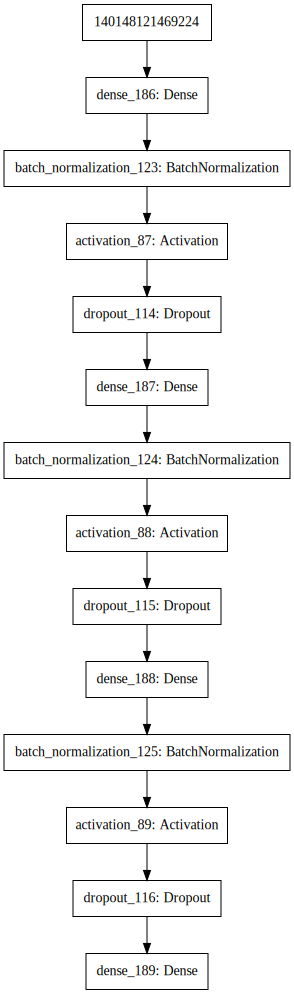

In [112]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot 

input_shape = train_x.shape
epochs = 50
batch_size = 128

model_11 = Sequential([
    InputLayer(input_shape=(input_shape[1], )),
    
    Dense(16, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    

    Dense(8, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(4, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(2, kernel_regularizer=regularizers.l2(0.001), activation='softmax',
             kernel_initializer='random_normal')
])
print(model_11.summary())


model_11.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Plot GRAPH
SVG(model_to_dot(model_11).create(prog='dot', format='svg'))


# history_11 = model_11.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
#                           validation_data=(val_x, val_y))
# evals = model_11.evaluate(test_x, test_y)
# print(evals)

# 12) Attempt to create the model with the best test score

In [0]:
# Create model
input_shape = (x_train.shape[1], )
best_model = Sequential([
    InputLayer(input_shape=input_shape),
    Dense(16, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    
    Dense(8, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    Dense(2, kernel_regularizer=regularizers.l2(0.001),
          kernel_initializer='random_normal', activation='softmax')

])

In [11]:
# handle with tensorboard
! pip install tensorboardcolab
%load_ext tensorboard

In [12]:
# Train model
from tensorboardcolab import *

batch_size = 1024
epochs = 3000


best_model.compile(optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                                             epsilon=None, decay=0.000000001 / 100000000),
                   loss='categorical_crossentropy', metrics=['accuracy'])
print(best_model.summary())


model_checkpoint = ModelCheckpoint('best_model-{epoch:02d}-{val_acc:.2f}b.h5', verbose=1, save_best_only=True)

# Create tensorboard callback
tbc=TensorBoardColab()

dense_net_history = best_model.fit(x_train, y_train, epochs=epochs, 
                                        batch_size=batch_size, validation_data=(val_x, val_y), 
                                        callbacks=[TensorBoardColabCallback(tbc), model_checkpoint])
evals = best_model.evaluate(test_x, test_y)
print(evals)
best_model.save_weights('last_epoch_b.h5')

import glob

evals = []
files = []
for file in glob.glob("*b.h5"):
    best_model.load_weights(file)
    eval = best_model.evaluate(test_x, test_y)
    evals.append(eval)
    files.append(file)

for eval, file in zip(evals, files):
    print(file, eval)

W0824 18:46:26.414204 139674224473984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0824 18:46:26.423166 139674224473984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                288       
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
batch_normalization_4 (Batch (None, 8)                 32        
_________________________________________________________________
activation_4 (Activation)    (None, 8)                 0         
__________

W0824 18:46:39.541669 139674224473984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0824 18:46:40.104326 139674224473984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorboardcolab/core.py:49: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Train on 75883 samples, validate on 32522 samples


W0824 18:46:41.228550 139674224473984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.



Epoch 1/3000
75883/75883 [==============================] - 1s 18us/step - loss: 0.6946 - acc: 0.5016 - val_loss: 0.6937 - val_acc: 0.5099

Epoch 00001: val_loss improved from inf to 0.69372, saving model to best_model-01-0.51b.h5
Epoch 2/3000
75883/75883 [==============================] - 1s 8us/step - loss: 0.6938 - acc: 0.5054 - val_loss: 0.6934 - val_acc: 0.5121

Epoch 00002: val_loss improved from 0.69372 to 0.69340, saving model to best_model-02-0.51b.h5
Epoch 3/3000
75883/75883 [==============================] - 1s 8us/step - loss: 0.6936 - acc: 0.5077 - val_loss: 0.6933 - val_acc: 0.5125

Epoch 00003: val_loss improved from 0.69340 to 0.69333, saving model to best_model-03-0.51b.h5
Epoch 4/3000
75883/75883 [==============================] - 1s 8us/step - loss: 0.6933 - acc: 0.5119 - val_loss: 0.6932 - val_acc: 0.5172

Epoch 00004: val_loss improved from 0.69333 to 0.69318, saving model to best_model-04-0.52b.h5
Epoch 5/3000
75883/75883 [==============================] - 1s 8us/

### Наилучшей оказалась модель "best_model-381-0.52b.h5" с точностью - 0.5212753206387878